In [25]:
%matplotlib notebook
import pandas as pd
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
import xgboost
from xgboost import XGBClassifier

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
data_path = '/home/mvkrein/etf_model/data'
etf_data_file = os.path.join(data_path,'etf_new_var_20180910.csv')
etf_data = pd.read_csv(etf_data_file,index_col=0)

In [4]:
etf_study_file = os.path.join(data_path,'ETF_list_min_6yr_history.csv')
etf_list = pd.read_csv(etf_study_file,index_col=0)
etf_data.sort_values(['Date','sym'],ascending=True,inplace=True)
etf_data.reset_index(drop=True,inplace=True)

In [5]:
drop_columns = ['Date','sym','p', 'v', 'p_L05', 'v_L05', 'p_L10', 'v_L10', 'p_L21', 'v_L21', 'p_L42', 'v_L42', 'p_L63', \
                'v_L63', 'p_L84', 'v_L84', 'p_L126', 'v_L126', 'p_L189', 'v_L189', 'p_L252', 'v_L252',\
                'p_L-21', 'v_L-21', 'delta_p_L05', 'delta_p_L10', 'delta_p_L21', 'delta_p_L42', 'delta_p_L63', \
                'delta_p_L84', 'delta_p_L126', 'delta_p_L189', 'delta_p_L252', 'delta_p_L-21', 'delta_v_L05',\
                'delta_v_L10', 'delta_v_L21', 'delta_v_L42', 'delta_v_L63', 'delta_v_L84', 'delta_v_L126', \
                'delta_v_L189', 'delta_v_L252','rank_p_L-21', 'ivv_delta_p_L-21', 'target']

rank_col = ['rank_p_L05','rank_p_L10','rank_p_L21','rank_p_L42',\
            'rank_p_L63','rank_p_L84','rank_p_L126','rank_p_L189','rank_p_L252']

In [6]:
all_columns = list(etf_data.columns)

In [7]:
include_columns = [x for x in all_columns if x not in drop_columns]
# include_columns = ['rank_p_L05','rank_p_L10','rank_p_L21','rank_p_L42',\
#             'rank_p_L63','rank_p_L84','rank_p_L126','rank_p_L189','rank_p_L252']
# include_columns = ['rank_p_L05','rank_p_L21','rank_p_L42','rank_p_L252']

In [8]:
str(1 % 21)

'1'

In [9]:
len(include_columns)

360

In [10]:
dates = list(etf_data['Date'].unique())
# dates[1671]

In [11]:
symbols = etf_list['Symbol'].unique()

In [12]:
len(symbols)

153

In [13]:
#Each year has 252 trading dates.  Need two years to fully develop variables.
dt1 = 504 #This is the first day that all variables are developed
# dt1 = 504 + 21 + 273 #This is the first day that all variables are developed 2016-04-07
# make all dates relative to dt1
# for one year training - add 252
# to evaluate for one month outside the training window - add 273
# to predict for the first day outside of the evaluation window (have to lag 21) - add 294
dt_end = (len(dates) - 273 - 21) - 1
# dt_end = dt1 + 1
etf_predict_file = os.path.join(data_path,'etf_linear_lasso_20180928.csv')

In [19]:
i = dt1 + 21
print("Building model to predict for ",dates[i+273])
x_train = etf_data.loc[((etf_data['Date']>=dates[i]) & (etf_data['Date']<dates[i+252])),include_columns] #train with 12 mos
y_train = etf_data.loc[((etf_data['Date']>=dates[i]) & (etf_data['Date']<dates[i+252])),['rank_p_L-21']] #train with 12 mos

x_test = etf_data.loc[(etf_data['Date']==dates[i+273]),include_columns]#predict one day-must be 21 days removed from training
y_test = etf_data.loc[(etf_data['Date']==dates[i+273]),['rank_p_L-21']] #predict if etf >= market
returns = etf_data.loc[(etf_data['Date']==dates[i+273]),['delta_p_L-21']]
mkt_return = etf_data.loc[(etf_data['Date']==dates[i+273]),['ivv_delta_p_L-21']]
x_train_nmpy = x_train.as_matrix()
y_train_nmpy = np.ravel(y_train.as_matrix())

x_test_nmpy = x_test.as_matrix()
y_test_nmpy = np.ravel(y_test.as_matrix())
returns_nmpy = returns.as_matrix()
mkt_return_nmpy = mkt_return.as_matrix()

#     lm = linear_model.Ridge (alpha = 0.8)
#     lm = linear_model.Lasso(alpha=0.0019)
lm = LassoCV(cv=5,random_state=54321,verbose=1,n_jobs=32,max_iter=10000)
#     lm = LinearRegression()

lm.fit(x_train_nmpy, y_train_nmpy)



Building model to predict for  2015-03-09


...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=32)]: Done   2 out of   5 | elapsed:    3.3s remaining:    5.0s
.....[Parallel(n_jobs=32)]: Done   5 out of   5 | elapsed:    3.9s finished


LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=32, normalize=False,
    positive=False, precompute='auto', random_state=54321,
    selection='cyclic', tol=0.0001, verbose=1)

In [24]:
lm.alpha_

0.001922560911205997

In [22]:
model_coef = pd.DataFrame({'Feature':include_columns,'Coefficient': lm.coef_})
model_coef.sort_values(by='Coefficient',inplace=True,ascending=False) 
model_coef.reset_index(drop=True,inplace=True)
model_coef.loc[abs(model_coef['Coefficient'])>0,]

,Coefficient,Feature
0,0.120368,w42_rank_p_L42_avg
1,0.056776,w252_rank_p_L252_avg
2,0.055422,w5_rank_v_L63_avg
3,0.050248,w5_rank_p_L63_avg
4,0.028570,w42_rank_v_L42_avg
5,0.015645,rank_p_L63
6,0.008797,w252_rank_v_L252_avg
353,-0.014830,w5_rank_v_L10_avg
354,-0.032587,w10_rank_v_L84_avg
355,-0.034619,w84_rank_v_L84_avg


In [42]:
i = dt1 +21
print("Building model to predict for ",dates[i+273])
x_train = etf_data.loc[((etf_data['Date']>=dates[i]) & (etf_data['Date']<dates[i+252])),include_columns] #train with 12 mos
y_train = etf_data.loc[((etf_data['Date']>=dates[i]) & (etf_data['Date']<dates[i+252])),['rank_p_L-21']] #train with 12 mos

x_test = etf_data.loc[(etf_data['Date']==dates[i+273]),include_columns]#predict one day-must be 21 days removed from training
y_test = etf_data.loc[(etf_data['Date']==dates[i+273]),['rank_p_L-21']] #predict if etf >= market
returns = etf_data.loc[(etf_data['Date']==dates[i+273]),['delta_p_L-21']]
mkt_return = etf_data.loc[(etf_data['Date']==dates[i+273]),['ivv_delta_p_L-21']]
x_train_nmpy = x_train.as_matrix()
y_train_nmpy = np.ravel(y_train.as_matrix())

x_test_nmpy = x_test.as_matrix()
y_test_nmpy = np.ravel(y_test.as_matrix())
returns_nmpy = returns.as_matrix()
mkt_return_nmpy = mkt_return.as_matrix()

#     lm = linear_model.Ridge (alpha = 0.8)
#     lm = linear_model.Lasso(alpha=0.0019)
lm = RidgeCV(cv=5,alphas=[100,200,300,500,1000,5000])
#     lm = LinearRegression()

lm.fit(x_train_nmpy, y_train_nmpy)

Building model to predict for  2015-03-09


RidgeCV(alphas=[100, 200, 300, 500, 1000, 5000], cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [43]:
lm.alpha_

1000

In [44]:
model_coef = pd.DataFrame({'Feature':include_columns,'Coefficient': lm.coef_})
model_coef.sort_values(by='Coefficient',inplace=True,ascending=False) 
model_coef.reset_index(drop=True,inplace=True)
model_coef

,Coefficient,Feature
0,0.045795,w252_rank_v_L252_avg
1,0.045795,w252_rank_p_L252_avg
2,0.037021,w42_rank_p_L42_avg
3,0.037021,w42_rank_v_L42_avg
4,0.034843,w252_rank_v_L189_avg
5,0.034843,w252_rank_p_L189_avg
6,0.034223,w5_rank_v_L63_avg
7,0.034223,w5_rank_p_L63_avg
8,0.033577,w42_rank_p_L189_avg
9,0.033577,w42_rank_v_L189_avg


In [63]:

for i in range(dt1,dt_end,21):
    print("Building model to predict for ",dates[i+273])
    x_train = etf_data.loc[((etf_data['Date']>=dates[i]) & (etf_data['Date']<dates[i+252])),include_columns] #train with 12 mos
    y_train = etf_data.loc[((etf_data['Date']>=dates[i]) & (etf_data['Date']<dates[i+252])),['rank_p_L-21']] #train with 12 mos

    x_test = etf_data.loc[(etf_data['Date']==dates[i+273]),include_columns]#predict one day-must be 21 days removed from training
    y_test = etf_data.loc[(etf_data['Date']==dates[i+273]),['rank_p_L-21']] #predict if etf >= market
    returns = etf_data.loc[(etf_data['Date']==dates[i+273]),['delta_p_L-21']]
    mkt_return = etf_data.loc[(etf_data['Date']==dates[i+273]),['ivv_delta_p_L-21']]
    x_train_nmpy = x_train.as_matrix()
    y_train_nmpy = np.ravel(y_train.as_matrix())

    x_test_nmpy = x_test.as_matrix()
    y_test_nmpy = np.ravel(y_test.as_matrix())
    returns_nmpy = returns.as_matrix()
    mkt_return_nmpy = mkt_return.as_matrix()

#     lm = linear_model.Ridge (alpha = 0.8)
    lm = linear_model.Lasso (alpha = 0.00019)
#     lm = LinearRegression()

    lm.fit(x_train_nmpy, y_train_nmpy)
    
    y_train_model = lm.predict(x_train_nmpy)
    y_pred_model = lm.predict(x_test_nmpy)


    y_check = np.column_stack((y_test_nmpy, y_pred_model,mkt_return_nmpy,returns_nmpy))
    y_check_df = pd.DataFrame(y_check,columns=['true_value','pred_value','mkt_return','returns'])
    y_check_df.sort_values('pred_value',inplace=True,ascending=False)
    

    train_error = mean_squared_error(y_train_nmpy,lm.predict(x_train_nmpy))
    eval_error = mean_squared_error(y_test_nmpy,y_pred_model)

    print('Model Eval Results:')
    print('*****************************')

    print(f'training error: {train_error:.3}')
    print(f'evaluation error: {eval_error:.3}')
    print('R-squared score (training): {:.3f}'
     .format(r2_score(y_train_nmpy,y_train_model)))
    print('R-squared score (test): {:.3f}'
     .format(r2_score(y_test_nmpy, y_pred_model)))

    print('*****************************')
    print("Model Top 5 Picks")
    print(" Avg rtn top 5:", round(y_check_df['returns'][0:5].mean(),4))
    print(y_check_df.head(5))
    print("Model Bottom 5 Picks")
    print(" Avg rtn bottom 5:", round(y_check_df['returns'][-5:].mean(),4))
    print(y_check_df.tail(5))
    print('********************************************************')
    if i == dt1:
        predict_data = etf_data.loc[(etf_data['Date']==dates[i+273]),['Date','sym','rank_p_L-21']]
        predict_data['predict'] = y_pred_model
        predict_data.to_csv(etf_predict_file)
    else:
        predict_data = etf_data.loc[(etf_data['Date']==dates[i+273]),['Date','sym','rank_p_L-21']]
        predict_data['predict'] = y_pred_model
        predict_data.to_csv(etf_predict_file,header=False,mode='a')

Building model to predict for  2015-02-05
Model Eval Results:
*****************************
training error: 0.0747
evaluation error: 0.0635
R-squared score (training): 0.103
R-squared score (test): 0.238
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0497
     true_value  pred_value  mkt_return   returns
139    0.960784    0.687726    0.010741  0.060291
70     0.986928    0.671993    0.010741  0.071770
67     0.882353    0.642061    0.010741  0.031835
45     0.888889    0.639172    0.010741  0.036401
66     0.947712    0.637022    0.010741  0.048248
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0258
    true_value  pred_value  mkt_return   returns
62    0.418301    0.383973    0.010741 -0.006829
26    0.424837    0.378687    0.010741 -0.006699
57    0.039216    0.363467    0.010741 -0.085190
39    0.287582    0.345077    0.010741 -0.016544
23    0.326797    0.294466    0.010741 -0.013518
********************************************************
Building model to predict 

Model Eval Results:
*****************************
training error: 0.0652
evaluation error: 0.098
R-squared score (training): 0.217
R-squared score (test): -0.176
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0377
     true_value  pred_value  mkt_return   returns
143    0.091503    0.845038   -0.003687 -0.057326
50     0.084967    0.825343   -0.003687 -0.057692
62     0.026144    0.727150   -0.003687 -0.094929
139    0.947712    0.716341   -0.003687  0.028113
89     0.444444    0.662159   -0.003687 -0.006480
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0197
    true_value  pred_value  mkt_return   returns
58    0.366013    0.340657   -0.003687 -0.010321
51    0.169935    0.335746   -0.003687 -0.036261
47    0.241830    0.334160   -0.003687 -0.020913
48    0.196078    0.263068   -0.003687 -0.029400
15    0.653595    0.252169   -0.003687 -0.001742
********************************************************
Building model to predict for  2015-12-04
Model Eval Results:
*****

/home/mvkrein/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Model Eval Results:
*****************************
training error: 0.0663
evaluation error: 0.109
R-squared score (training): 0.204
R-squared score (test): -0.305
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.016
     true_value  pred_value  mkt_return   returns
70     0.006536    0.944500    0.008977 -0.090559
88     0.013072    0.912192    0.008977 -0.079832
117    0.921569    0.725384    0.008977  0.061634
24     0.111111    0.718892    0.008977 -0.011566
66     0.830065    0.691768    0.008977  0.040135
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.001
    true_value  pred_value  mkt_return   returns
17    0.202614    0.246423    0.008977 -0.001238
53    0.150327    0.240671    0.008977 -0.007082
6     0.176471    0.231694    0.008977 -0.005029
50    0.045752    0.175869    0.008977 -0.038139
32    0.901961    0.049648    0.008977  0.056305
********************************************************
Building model to predict for  2016-05-06
Model Eval Results:
********

Model Eval Results:
*****************************
training error: 0.0676
evaluation error: 0.117
R-squared score (training): 0.188
R-squared score (test): -0.399
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0012
    true_value  pred_value  mkt_return   returns
33    0.183007    0.784279    0.011592 -0.001021
76    0.653595    0.744395    0.011592  0.015639
47    0.156863    0.737503    0.011592 -0.001833
48    0.104575    0.734727    0.011592 -0.006385
58    0.202614    0.734512    0.011592 -0.000284
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0447
     true_value  pred_value  mkt_return   returns
138    0.960784    0.244132    0.011592  0.067259
143    0.784314    0.241766    0.011592  0.028379
30     0.790850    0.240194    0.011592  0.028412
14     0.934641    0.238695    0.011592  0.056055
31     0.849673    0.134429    0.011592  0.043210
********************************************************
Building model to predict for  2017-02-06
Model Eval Results:
*******

Model Eval Results:
*****************************
training error: 0.0742
evaluation error: 0.0847
R-squared score (training): 0.109
R-squared score (test): -0.016
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0117
     true_value  pred_value  mkt_return   returns
52     0.019608    0.743993    0.014822 -0.071667
138    0.725490    0.737055    0.014822  0.014659
29     0.745098    0.721161    0.014822  0.015203
126    0.359477    0.686885    0.014822  0.001369
148    0.091503    0.672909    0.014822 -0.018113
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0027
     true_value  pred_value  mkt_return   returns
117    0.836601    0.334034    0.014822  0.020555
95     0.084967    0.328446    0.014822 -0.018722
66     0.189542    0.317539    0.014822 -0.009052
75     0.934641    0.306532    0.014822  0.037583
78     0.052288    0.269663    0.014822 -0.043677
********************************************************
Building model to predict for  2017-11-03
Model Eval Results

Model Eval Results:
*****************************
training error: 0.0726
evaluation error: 0.0913
R-squared score (training): 0.128
R-squared score (test): -0.096
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0197
     true_value  pred_value  mkt_return   returns
14     0.581699    0.764939    0.027376  0.007524
148    0.006536    0.730704    0.027376 -0.129697
57     0.183007    0.702717    0.027376 -0.011736
32     0.026144    0.688421    0.027376 -0.038342
55     0.986928    0.671372    0.027376  0.073643
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0131
     true_value  pred_value  mkt_return   returns
146    0.078431    0.358858    0.027376 -0.024801
112    0.045752    0.356439    0.027376 -0.032514
75     0.150327    0.326414    0.027376 -0.013146
25     0.699346    0.316986    0.027376  0.018281
84     0.143791    0.314509    0.027376 -0.013180
********************************************************


In [45]:
lm.intercept_

0.4093587584945939

In [50]:
model_coef = pd.DataFrame({'Feature':include_columns,'Coefficient': lm.coef_})
model_coef.sort_values(by='Coefficient',inplace=True,ascending=False) 
model_coef.reset_index(drop=True,inplace=True)
model_coef

,Coefficient,Feature
0,0.593016,w42_rank_p_L252_avg
1,0.590215,w42_rank_v_L252_avg
2,0.403456,w42_rank_p_L84_avg
3,0.391652,w42_rank_v_L84_avg
4,0.362188,w126_rank_p_L05_avg
5,0.348371,w126_rank_p_L21_avg
6,0.327921,w126_rank_v_L21_avg
7,0.312515,w252_rank_p_L21_avg
8,0.272693,w126_rank_v_L05_avg
9,0.256563,w252_rank_v_L21_avg


<IPython.core.display.Javascript object>


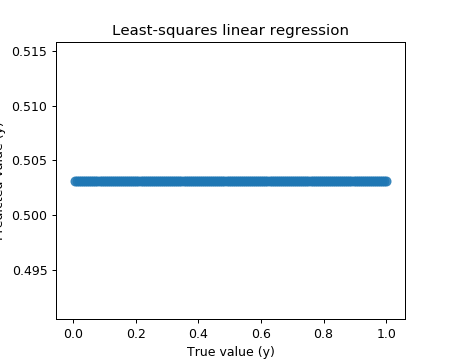

In [41]:
plt.figure(figsize=(5,4))
plt.scatter(y_test_nmpy, y_pred_model,marker= 'o', s=50, alpha=0.8)
#plt.plot(y_test_nmpy, y_pred_model, 'r-')
plt.title('Least-squares linear regression')
plt.xlabel('True value (y)')
plt.ylabel('Predicted value (y)')
plt.show()